# Import the necessary header files required

In [16]:
import torch
import torch.nn as nn                   #for sequence api in torch
from torch.utils.data import DataLoader #for loading images
import numpy as np                      #just in case if you need numpy arrays
import torchvision.transforms as T      #Used for data preprocessing and converting images to tensors
import torchvision.datasets as dset
import torch.optim as optim             #For using the desired parameter update
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import random

USE_GPU = True

if USE_GPU and torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

dtype = torch.float32

print("Using device: ",device)

Using device:  cuda


# Data loading and preprocessing

In [17]:
transform = T.Compose([T.RandomHorizontalFlip(),T.ToTensor()])
#Training
train_data = dset.ImageFolder("images/train",transform=transform)
loaded_train = DataLoader(train_data,batch_size=4,shuffle=True)
#Validation
validation_data = dset.ImageFolder("images/validation",transform=transform)
loaded_validation = DataLoader(validation_data,batch_size=4,shuffle=False)

loss_history = []
validation_acc = []
training_acc = []

# Calculating the number of images in each class of the training set

In [18]:
num_classes = 7
class_count = [0] * num_classes
for img, label in train_data:
    class_count[label] += 1

for num, class_lab in zip(class_count, train_data.classes):
    print(f"{class_lab}:{num}")
print(f"Total number of images: {sum(class_count)}")
print(f"Class with the maximum number of images: {train_data.classes[class_count.index(max(class_count))]}({max(class_count)})")
print(f"Class with the minimum number of images: {train_data.classes[class_count.index(min(class_count))]}({min(class_count)})")

angry:3993
disgust:436
fear:4103
happy:7164
neutral:4982
sad:4938
surprise:3205
Total number of images: 28821
Class with the maximum number of images: happy(7164)
Class with the minimum number of images: disgust(436)


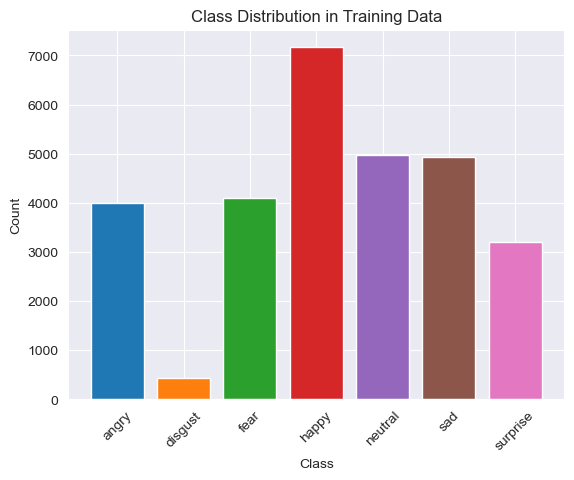

In [19]:
# Plotting the class distribution
fig, ax = plt.subplots()
colors = plt.cm.tab10(np.arange(num_classes))
ax.bar(train_data.classes, class_count, color=colors)  # Use class names as x-axis labels
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Class Distribution in Training Data')
ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Visualizing the image

Target label:  sad


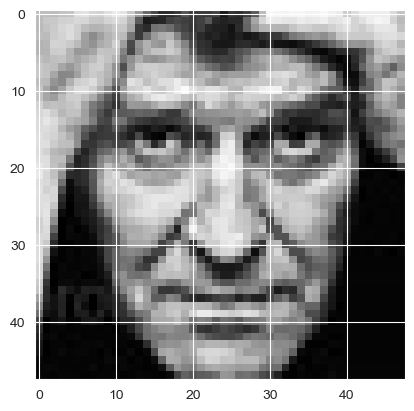

In [20]:
dataiter = iter(loaded_train)   #The iter() function in python represents the iterator similar to c++ iterators
images, labels = dataiter.__next__() #The next() method retrieves the object
expression = {0:"angry",1:"disgust",2:"fear",3:"happy",4:"neutral",5:"sad",6:"surprise"} #Create a dictionary for mapping accordingly
random_idx = random.sample(range(0,4),1)[0]     #Selects a random single number from 0-64
print("Target label: ",expression[int(labels[random_idx].numpy())])  #Converting it to numpy from tensor to fetch the label
plt.imshow(np.transpose(images[random_idx].numpy(), (1, 2, 0)))

# Our model

In [21]:
model = None
optimizer = None

#First architecture #3,32,32
conv1 = nn.Sequential(
    nn.Conv2d(3,512,kernel_size=(3,3),bias=True,padding=1), #512,48,48
    nn.BatchNorm2d(512),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2))  #Sampling image to half  512,24,24
)
conv2 = nn.Sequential(
    nn.Conv2d(512,128,kernel_size=(3,3),padding=1,bias=True), #128,24,24
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2))         #128,12,12
)
conv3 = nn.Sequential(
    nn.Conv2d(128,64,kernel_size=(3,3),bias=True,padding=1), #64,12,12
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2))   #64,6,6
)
conv4 = nn.Sequential(
    nn.Conv2d(64,256,kernel_size=(3,3),bias=True,padding=1), #64,6,6
    nn.BatchNorm2d(256),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2,2))   #256,3,3
)
fc = nn.Sequential(
    nn.Flatten(),
    nn.Linear(256*3*3,7),
)

model = nn.Sequential(
    conv1,
    conv2,
    conv3,
    conv4,
    fc
)


In [22]:
model = None
optimizer = None

class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        # Initial convolutional layer
        self.conv1 = nn.Conv2d(3, 512, kernel_size=(3, 3), bias=True, padding=1)

        # VGG16 architecture (excluding the specified initial layer)
        self.features = nn.Sequential(
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=(3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=(3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Classification layer with 7 output classes
        self.classifier = nn.Sequential(
            nn.Linear(512 * 48 * 48, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 7)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Create an instance of the VGG16 model
model = VGG16()

# Creating a method for predicting validation accuracy

In [23]:
def check_accuracy_part(loader, model):
    print('Checking accuracy on validation set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

# Training function

In [24]:
def train_part(model, optimizer, epochs=1):
    """
    Train a model using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print("epoch: ",e+1)
        for t, (x, y) in enumerate(loaded_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % 100 == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part(loaded_validation, model)
                print()

# Training the model


In [25]:
learning_rate=0.001
optimizer = optim.Adam(model.parameters(),lr=learning_rate)
train_part(model, optimizer, epochs=10)

OutOfMemoryError: CUDA out of memory. Tried to allocate 18.00 GiB (GPU 0; 6.00 GiB total capacity; 90.13 MiB already allocated; 4.92 GiB free; 102.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
# TODO: resample the dataset to have equal number of images for each class and train the model again